In [131]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt


In [132]:
seed=3
torch.manual_seed(seed)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

In [133]:
batch_size=64
num_epochs = 10
learning_rate = 0.01

In [134]:
train_ds = torchvision.datasets.FashionMNIST(root='../../data', download=True, train=True, transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.FashionMNIST(root='../../data', transform=torchvision.transforms.ToTensor())
train_dl = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

In [135]:
def show_samples(images):
    image_grid = torchvision.utils.make_grid(images, 8)
    plt.imshow(image_grid.permute(1,2,0))
    plt.show()

In [136]:
def show_orig_vs_recon(orig_batch, recon_batch):
    fig, axs = plt.subplots(2, 8, figsize=(20, 5))
    for j in range(8):
        axs[0][j].imshow(orig_batch[j].permute(1, 2, 0))
        axs[1][j].imshow(recon_batch[j].permute(1, 2, 0))
    plt.axis('off')
    plt.show()

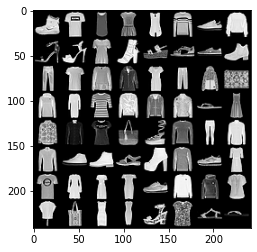

In [137]:
sample_images, _ = iter(test_dl).next()
show_samples(sample_images)


In [138]:
class VAEModel(nn.Module):
    """ An implementation of the variational Autoencoder

    Uses CNN based encoder and decoder.
    """
    def __init__(self):
        super(VAEModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5, stride=2), # output 6, 12, 12
            nn.ReLU(),
            #nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, 5), # output 16, 8, 8
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2), # output  32, 3, 3
            nn.ReLU(),
            nn.Conv2d(32, 64, 3), # output 64, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3), # output 32, 3, 3
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1, output_padding=1), # output 16, 8, 8
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 6, 5), # output 6, 12, 12
            nn.ReLU(),
            #nn.BatchNorm2d(6),
            nn.ConvTranspose2d(6, 1, 5, stride=2, output_padding=1), # output 1, 28, 28
        )
        self.mu = nn.Linear(64, 32)
        self.log_var = nn.Linear(64, 32)
        self.dec_lin = nn.Linear(32, 64)
    
    def reparametrize(self, mu, log_var):
        std = torch.exp(log_var/2)
        epsilon = torch.randn_like(std)
        z = mu + (epsilon * std)
        return z

    
    def forward(self, x):
        x_encoded = self.encoder(x)
        mu = self.mu(x_encoded.view(-1, 64))
        log_var = self.log_var(x_encoded.view(-1, 64))

        z = self.reparametrize(mu, log_var)

        z = self.dec_lin(z)
        z = z.view(-1, 64, 1, 1)
        recon = torch.sigmoid(self.decoder(z))
        return recon, mu, log_var



In [139]:
def vae_loss(bce_loss, mu, log_var):
    """ Computes the VAE loss based on ELBO

    In this case divergence from N(0,1) distribution is computed
    """
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce_loss + kl


In [140]:
def apply_on_test_batch(model, epoch):
    orig_batch, _ = iter(test_dl).next()
    with torch.no_grad():
        orig_batch.to(device)
        recon_batch, _, _ = model(orig_batch)
        orig_batch = orig_batch.cpu()
        recon_batch = recon_batch.cpu()
        print(f'Epoch {epoch + 1}, Orignal vs Reconstructed')
        show_orig_vs_recon(orig_batch[0:8], recon_batch[0:8])

Epoch 1, Orignal vs Reconstructed


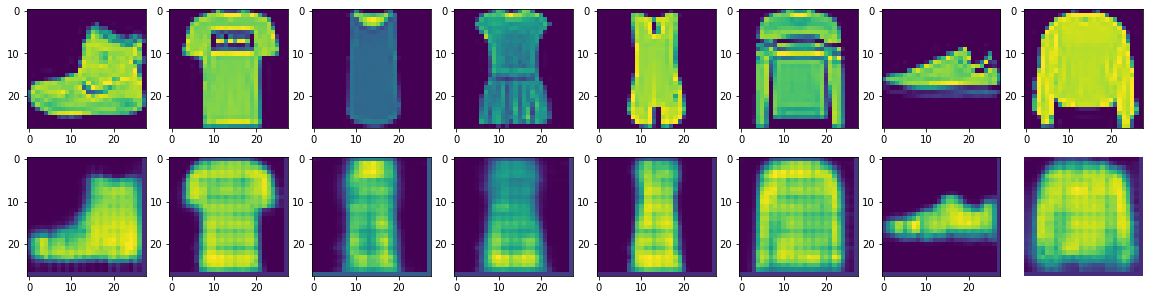

Epoch 2, Orignal vs Reconstructed


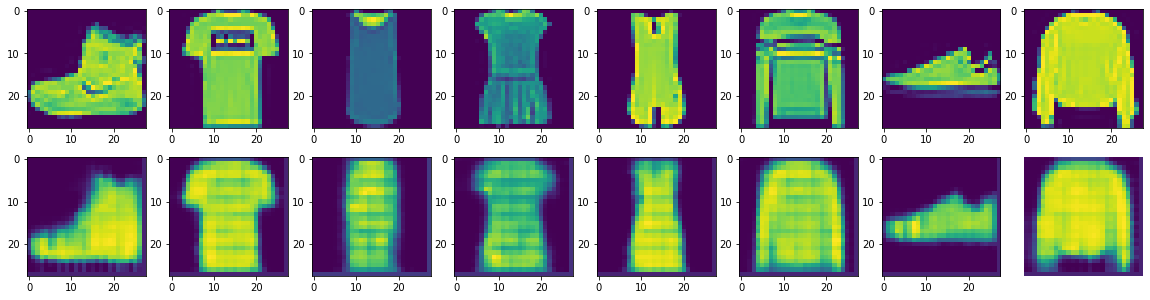

Epoch 3, Orignal vs Reconstructed


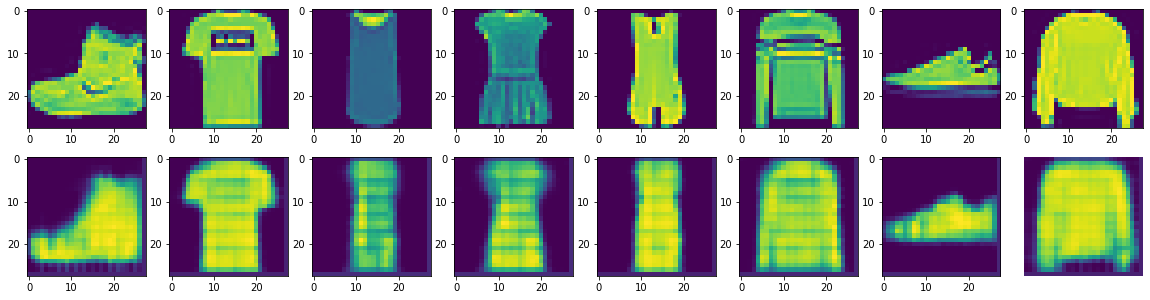

Epoch 4, Orignal vs Reconstructed


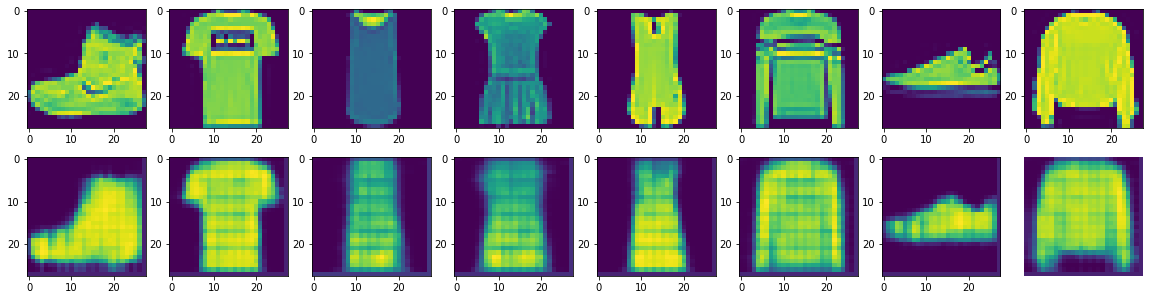

Epoch 5, Orignal vs Reconstructed


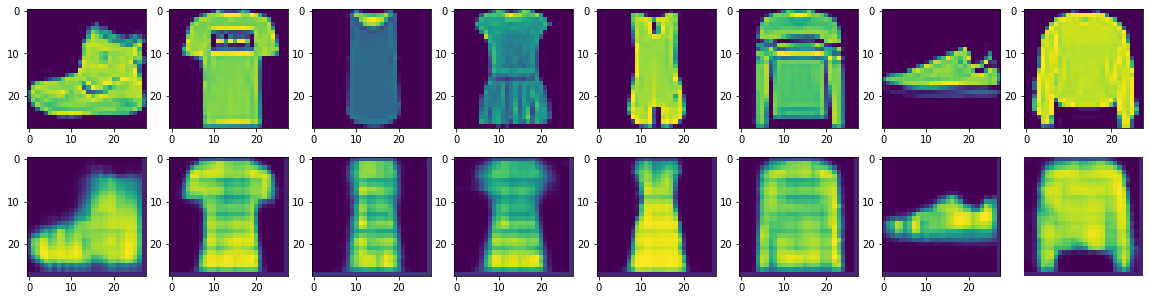

Epoch 6, Orignal vs Reconstructed


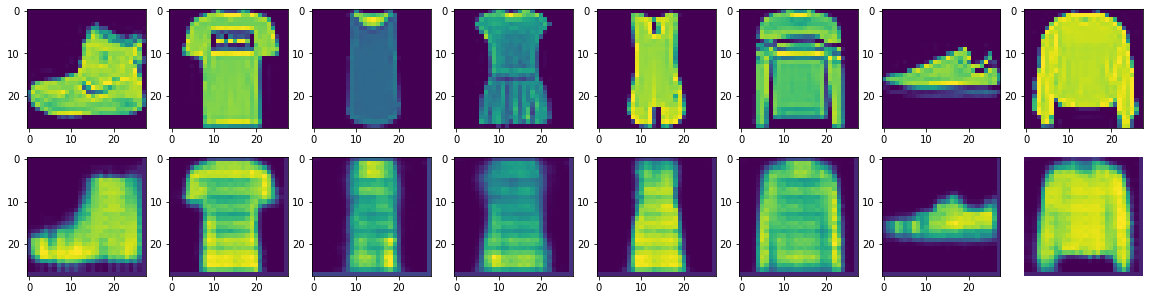

Epoch 7, Orignal vs Reconstructed


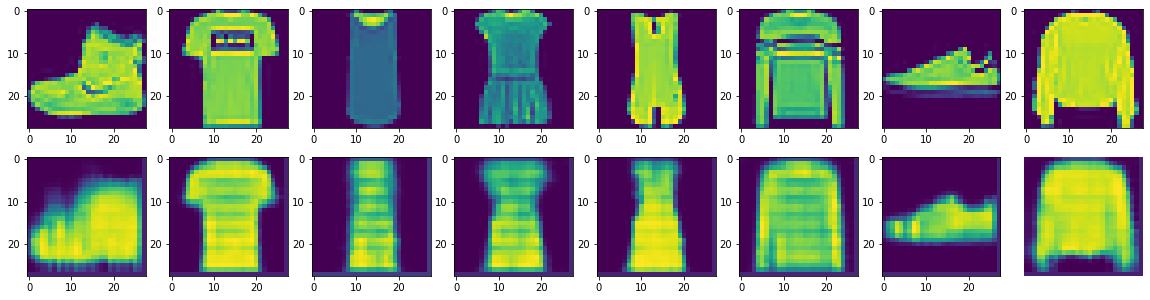

Epoch 8, Orignal vs Reconstructed


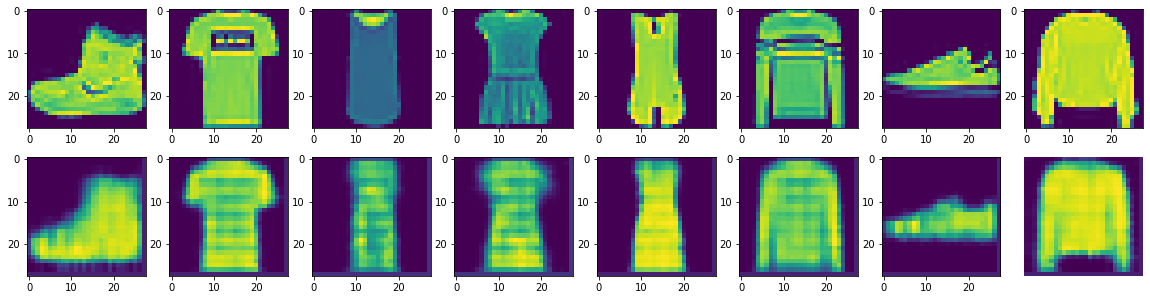

Epoch 9, Orignal vs Reconstructed


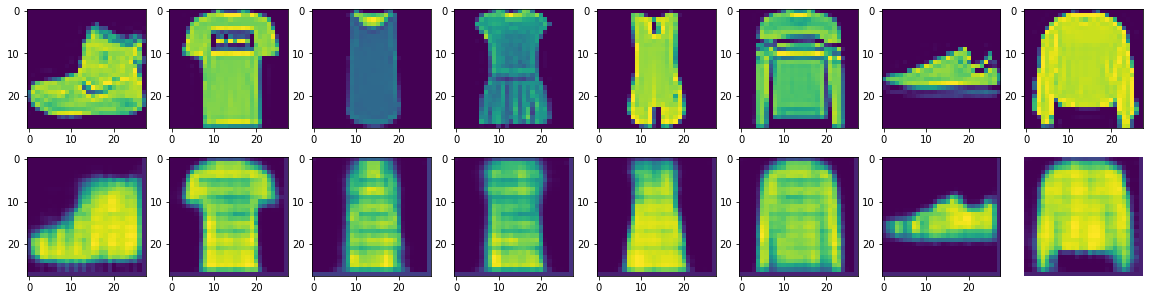

Epoch 10, Orignal vs Reconstructed


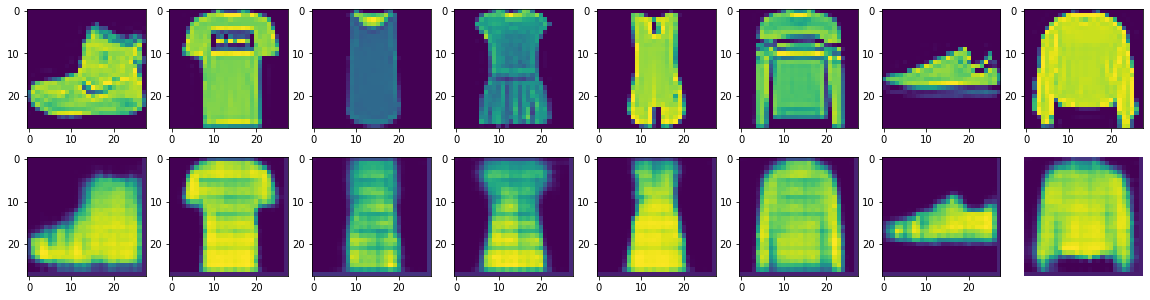

In [141]:
vae = VAEModel().to(device)
criterion = nn.BCELoss(reduction='sum')
optim = torch.optim.Adam(vae.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(train_dl):
        images = samples.to(device)
        recon, mu, log_var = vae(images)
        optim.zero_grad()
        recon_loss = criterion(recon, images)
        loss = vae_loss(recon_loss, mu, log_var)
        loss.backward()
        optim.step()
        if (i+1 % 100 == 0):
            print(f'epoch {epoch + 1} / num_epoch {num_epochs}, step {epoch * batch_size + i + 1}, loss = {loss.item():.4f} ')
    
    apply_on_test_batch(vae, epoch)
    

    
    